<a href="https://colab.research.google.com/github/Alan-Cheong/IEEE_QW_2020/blob/master/Superconductivity_Electron_Phonon_Interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

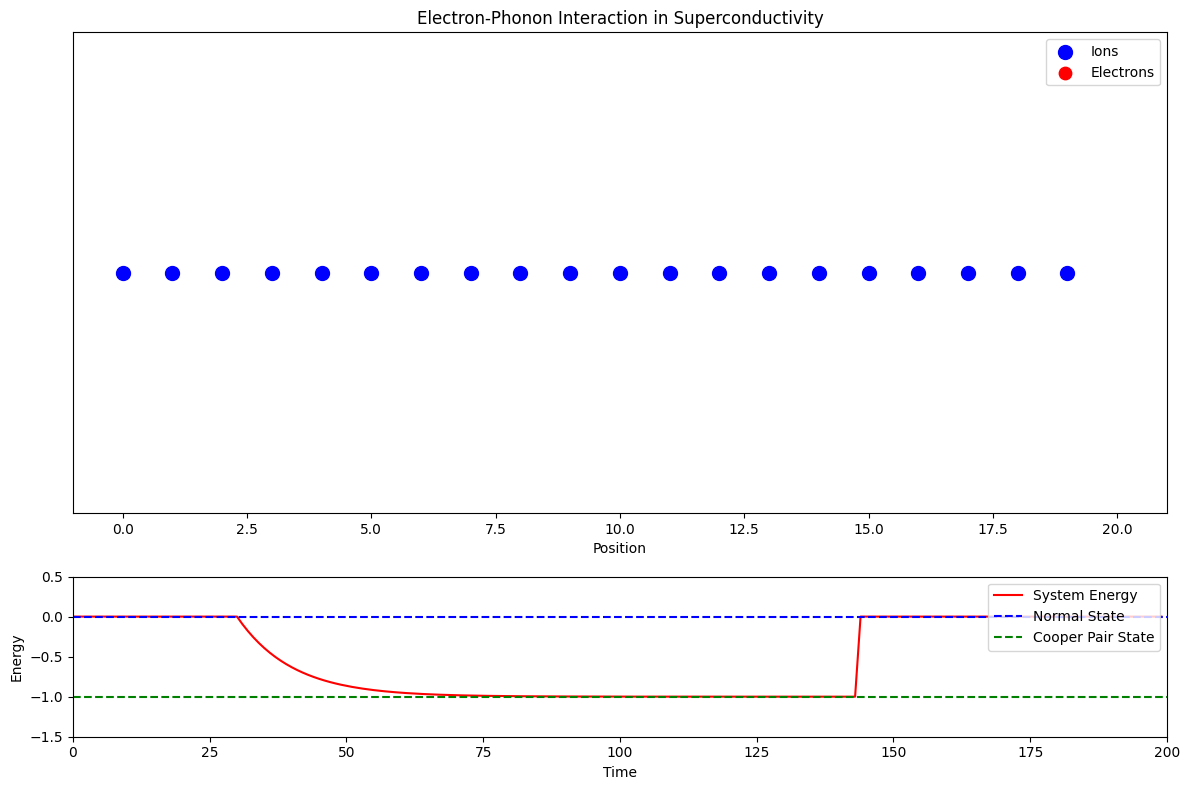

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.colors import to_rgba
from IPython.display import HTML # Import necessary module

class SuperconductivityAnimation:
    def __init__(self):
        # Simulation parameters
        self.num_ions = 20
        self.num_electrons = 2
        self.lattice_spacing = 1.0
        self.fig_size = (12, 8)
        self.animation_frames = 200
        self.delay_between_electrons = 20  # Frames between first and second electron

        # Physics parameters
        self.electron_velocity = 0.15
        self.distortion_strength = 0.2
        self.distortion_range = 3.0
        self.distortion_decay = 0.1
        self.attraction_strength = 0.05

        # Initialize positions
        self.ion_positions = np.array([
            [i * self.lattice_spacing, 0] for i in range(self.num_ions)
        ])
        self.ion_displacements = np.zeros((self.num_ions, 2))

        # Electron trajectories
        self.electron_positions = np.zeros((self.animation_frames, self.num_electrons, 2))
        self.electron_positions[:, :, 0] = -1  # Initialize off-screen
        self.electron_positions[:, :, 1] = self.lattice_spacing / 2

        # Interaction visualization
        self.interaction_strength = np.zeros((self.animation_frames, self.num_ions))

        # Setup figure and axes
        self.setup_figure()

    def setup_figure(self):
        """Set up the figure and axes for the animation"""
        self.fig = plt.figure(figsize=self.fig_size)
        gs = GridSpec(2, 1, height_ratios=[3, 1])

        # Lattice visualization
        self.ax_lattice = self.fig.add_subplot(gs[0])
        self.ax_lattice.set_xlim(-1, (self.num_ions + 1) * self.lattice_spacing)
        self.ax_lattice.set_ylim(-1, 1)
        self.ax_lattice.set_title("Electron-Phonon Interaction in Superconductivity")
        self.ax_lattice.set_xlabel("Position")
        self.ax_lattice.set_yticks([])

        # Energy level diagram
        self.ax_energy = self.fig.add_subplot(gs[1])
        self.ax_energy.set_xlim(0, self.animation_frames)
        self.ax_energy.set_ylim(-1.5, 0.5)
        self.ax_energy.set_ylabel("Energy")
        self.ax_energy.set_xlabel("Time")

        # Create artists for animation
        self.ion_scatter = self.ax_lattice.scatter(
            self.ion_positions[:, 0],
            self.ion_positions[:, 1],
            s=100, color='blue', label="Ions"
        )

        self.electron_scatter = self.ax_lattice.scatter(
            [], [], s=80, color='red', label="Electrons"
        )

        self.distortion_lines = []
        for i in range(self.num_ions):
            line, = self.ax_lattice.plot([], [], 'g-', alpha=0.3)
            self.distortion_lines.append(line)

        # For energy plot
        self.energy_line, = self.ax_energy.plot([], [], 'r-', label="System Energy")
        self.normal_energy = self.ax_energy.axhline(y=0, color='blue', linestyle='--', label="Normal State")
        self.paired_energy = self.ax_energy.axhline(y=-1, color='green', linestyle='--', label="Cooper Pair State")

        # Add annotation for Cooper pair
        self.cooper_pair_text = self.ax_lattice.text(
            self.num_ions * self.lattice_spacing / 2,
            0.8,
            "Cooper Pair Formation",
            ha='center',
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.7),
            visible=False
        )

        self.ax_lattice.legend(loc='upper right')
        self.ax_energy.legend(loc='upper right')
        self.fig.tight_layout()

    def simulate(self):
        """Run the simulation of electron movement and lattice distortion"""
        # First electron enters after some delay
        start_frame_e1 = 10

        # Calculate first electron positions
        for frame in range(start_frame_e1, self.animation_frames):
            pos = (frame - start_frame_e1) * self.electron_velocity
            if pos <= self.num_ions * self.lattice_spacing:
                self.electron_positions[frame, 0, 0] = pos

        # Second electron enters after first one
        start_frame_e2 = start_frame_e1 + self.delay_between_electrons

        # Calculate second electron positions (following the first with attraction)
        prev_pos = self.electron_positions[start_frame_e2, 0, 0]
        self.electron_positions[start_frame_e2, 1, 0] = 0

        for frame in range(start_frame_e2 + 1, self.animation_frames):
            # Normal movement
            pos = (frame - start_frame_e2) * self.electron_velocity

            # Add attraction to the first electron (Cooper pair formation)
            if frame > start_frame_e2 + 50:  # Start attraction after some time
                e1_pos = self.electron_positions[frame, 0, 0]
                distance = e1_pos - prev_pos
                attraction = self.attraction_strength * distance
                pos += attraction

            if pos <= self.num_ions * self.lattice_spacing:
                self.electron_positions[frame, 1, 0] = pos
            prev_pos = pos

        # Calculate lattice distortion for each frame
        for frame in range(self.animation_frames):
            # Reset displacements
            self.ion_displacements.fill(0)

            # For each electron that's on screen, calculate its effect on the lattice
            for e in range(self.num_electrons):
                e_pos = self.electron_positions[frame, e, 0]
                if e_pos > 0:
                    for i in range(self.num_ions):
                        ion_pos = self.ion_positions[i, 0]
                        distance = abs(e_pos - ion_pos)

                        # Apply distortion within range
                        if distance < self.distortion_range:
                            # Vertical displacement (attraction towards electron)
                            displacement = self.distortion_strength * np.exp(-distance * self.distortion_decay)
                            direction = -1 if e_pos > ion_pos else 1  # Direction of displacement
                            self.ion_displacements[i, 1] += displacement * direction

                            # Record interaction strength for visualization
                            self.interaction_strength[frame, i] = displacement

        # Calculate system energy
        energy = np.zeros(self.animation_frames)
        for frame in range(self.animation_frames):
            # Base energy is zero (normal state)
            energy[frame] = 0

            # If both electrons are present, calculate pair binding energy
            if (self.electron_positions[frame, 0, 0] > 0 and
                self.electron_positions[frame, 1, 0] > 0):

                distance = abs(self.electron_positions[frame, 0, 0] -
                               self.electron_positions[frame, 1, 0])

                # Cooper pairing lowers energy if electrons are close enough
                if distance < 5 * self.lattice_spacing:
                    # Energy gradually decreases to -1 as electrons get closer
                    energy[frame] = -1 * (1 - np.exp(-0.1 * (frame - start_frame_e2)))

        return energy

    def init_animation(self):
        """Initialize animation"""
        self.electron_scatter.set_offsets(np.zeros((0, 2)))
        for line in self.distortion_lines:
            line.set_data([], [])
        self.energy_line.set_data([], [])
        return [self.electron_scatter, *self.distortion_lines, self.energy_line, self.cooper_pair_text]

    def animate(self, frame):
        """Update animation for each frame"""
        # Update ion positions with calculated displacements
        displaced_positions = self.ion_positions + self.ion_displacements
        self.ion_scatter.set_offsets(displaced_positions)

        # Update electron positions (only show ones that are on screen)
        visible_electrons = []
        for e in range(self.num_electrons):
            if 0 <= self.electron_positions[frame, e, 0] <= self.num_ions * self.lattice_spacing:
                visible_electrons.append(self.electron_positions[frame, e])

        if visible_electrons:
            self.electron_scatter.set_offsets(visible_electrons)
        else:
            self.electron_scatter.set_offsets(np.zeros((0, 2)))

        # Update distortion visualization
        for i in range(self.num_ions):
            x = self.ion_positions[i, 0]
            y = self.ion_positions[i, 1] + self.ion_displacements[i, 1]
            self.distortion_lines[i].set_data([x, x], [0, y])

            # Change line color intensity based on distortion
            intensity = min(1.0, abs(self.ion_displacements[i, 1]) * 5)
            color = to_rgba('green', alpha=intensity * 0.8)
            self.distortion_lines[i].set_color(color)

        # Update energy plot
        self.energy_line.set_data(range(frame+1), self.energy[:frame+1])

        # Show Cooper pair text when both electrons are visible and close
        both_visible = (0 < self.electron_positions[frame, 0, 0] <= self.num_ions * self.lattice_spacing and
                        0 < self.electron_positions[frame, 1, 0] <= self.num_ions * self.lattice_spacing)

        if both_visible:
            distance = abs(self.electron_positions[frame, 0, 0] - self.electron_positions[frame, 1, 0])
            if distance < 4 * self.lattice_spacing and frame > 100:
                self.cooper_pair_text.set_visible(True)
                # Position text between electrons
                mid_x = (self.electron_positions[frame, 0, 0] + self.electron_positions[frame, 1, 0]) / 2
                self.cooper_pair_text.set_position((mid_x, 0.8))
            else:
                self.cooper_pair_text.set_visible(False)
        else:
            self.cooper_pair_text.set_visible(False)

        return [self.ion_scatter, self.electron_scatter, *self.distortion_lines,
                self.energy_line, self.cooper_pair_text]

    def create_animation(self):
        """Create and return the animation"""
        energy = self.simulate()
        self.energy = energy

        ani = animation.FuncAnimation(
            self.fig,
            self.animate,
            frames=self.animation_frames,
            init_func=self.init_animation,
            blit=True,
            interval=50
        )

        return ani

def run_animation():
    """Run the superconductivity animation"""
    sim = SuperconductivityAnimation()
    ani = sim.create_animation()
   # Instead of plt.show(), display the animation as HTML5 video
    display(HTML(ani.to_html5_video()))
    # To save as a video file (optional)
    # ani.save('superconductivity.mp4', writer='ffmpeg', fps=20)

    #plt.show()

if __name__ == "__main__":
    run_animation()




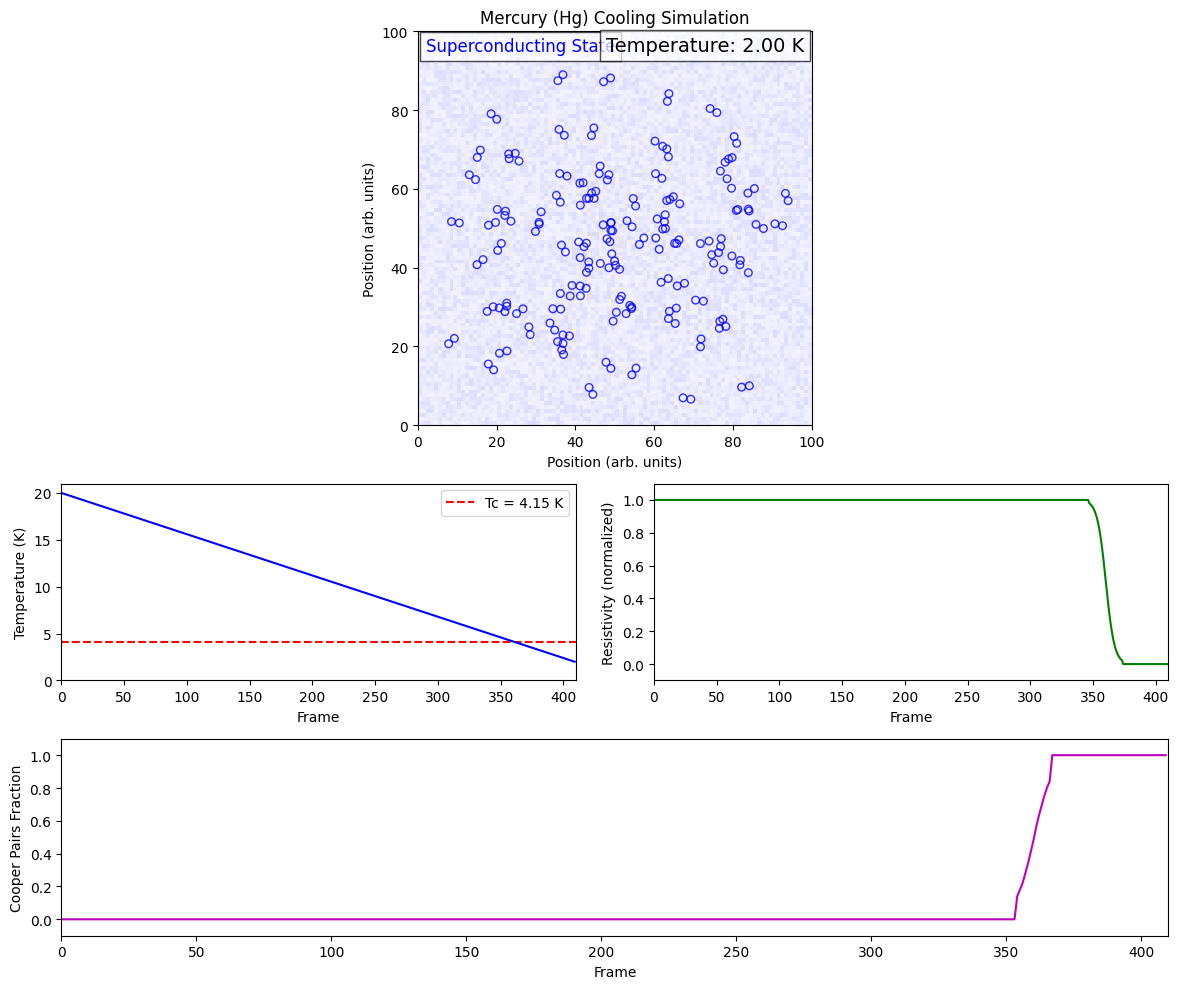

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from IPython.display import HTML # Import necessary module

class MercurySuperconductivitySimulation:
    def __init__(self):
        # Physical constants and parameters for mercury
        self.critical_temperature = 4.15  # Critical temperature in Kelvin
        self.start_temperature = 20.0     # Starting temperature in Kelvin
        self.final_temperature = 2.0      # Final temperature in Kelvin
        self.cooling_rate = 0.05          # Kelvin per frame
        self.transition_width = 0.3       # Width of the transition region

        # Simulation parameters
        self.grid_size = 100              # Size of the simulation grid
        self.num_electrons = 200          # Number of electrons to simulate
        self.num_frames = int((self.start_temperature - self.final_temperature) / self.cooling_rate) + 50

        # Create array for temperature at each frame
        self.temperature_array = np.linspace(self.start_temperature, self.final_temperature, self.num_frames)

        # Resistivity data (normalized)
        self.resistivity = np.zeros(self.num_frames)
        for i, temp in enumerate(self.temperature_array):
            self.resistivity[i] = self.calculate_resistivity(temp)

        # Initialize electron positions and velocities
        self.initialize_electrons()

        # Setup figure and axes for visualization
        self.setup_figure()

    def calculate_resistivity(self, temperature):
        """Calculate resistivity using a smooth transition function near Tc"""
        if temperature > self.critical_temperature + 2 * self.transition_width:
            # Normal state
            return 1.0
        elif temperature < self.critical_temperature - 2 * self.transition_width:
            # Superconducting state
            return 0.0
        else:
            # Transition region with a smooth curve
            x = (temperature - self.critical_temperature) / self.transition_width
            return 0.5 * (1 + np.tanh(x))

    def initialize_electrons(self):
        """Initialize electron positions and velocities"""
        # Positions array: [frame, electron_id, (x, y)]
        self.electron_positions = np.zeros((self.num_frames, self.num_electrons, 2))

        # Initial positions
        for i in range(self.num_electrons):
            x = np.random.uniform(0, self.grid_size)
            y = np.random.uniform(0, self.grid_size)
            self.electron_positions[0, i] = [x, y]

        # Electron colors for visualization (based on pairing)
        self.electron_colors = np.zeros((self.num_frames, self.num_electrons, 4))  # RGBA

        # Initialize all electrons as unpaired (red)
        self.electron_colors[0, :] = [1, 0, 0, 1]  # Red with full opacity

        # Paired state markers (0=unpaired, 1=paired)
        self.electron_paired = np.zeros((self.num_frames, self.num_electrons), dtype=bool)

        # Calculated paired electrons for each frame
        self.paired_ratio = np.zeros(self.num_frames)

    def setup_figure(self):
        """Setup the figure for visualization"""
        self.fig = plt.figure(figsize=(12, 10))
        gs = GridSpec(3, 2, height_ratios=[2, 1, 1])

        # Main visualization area
        self.ax_electrons = self.fig.add_subplot(gs[0, :])
        self.ax_electrons.set_xlim(0, self.grid_size)
        self.ax_electrons.set_ylim(0, self.grid_size)
        self.ax_electrons.set_title("Mercury (Hg) Cooling Simulation")
        self.ax_electrons.set_xlabel("Position (arb. units)")
        self.ax_electrons.set_ylabel("Position (arb. units)")

        # Temperature plot
        self.ax_temp = self.fig.add_subplot(gs[1, 0])
        self.ax_temp.set_xlim(0, self.num_frames)
        self.ax_temp.set_ylim(0, self.start_temperature + 1)
        self.ax_temp.set_ylabel("Temperature (K)")
        self.ax_temp.set_xlabel("Frame")
        self.ax_temp.axhline(y=self.critical_temperature, color='r', linestyle='--',
                             label=f"Tc = {self.critical_temperature} K")
        self.ax_temp.legend()

        # Resistivity plot
        self.ax_resistivity = self.fig.add_subplot(gs[1, 1])
        self.ax_resistivity.set_xlim(0, self.num_frames)
        self.ax_resistivity.set_ylim(-0.1, 1.1)
        self.ax_resistivity.set_ylabel("Resistivity (normalized)")
        self.ax_resistivity.set_xlabel("Frame")

        # Paired electrons percentage plot
        self.ax_paired = self.fig.add_subplot(gs[2, :])
        self.ax_paired.set_xlim(0, self.num_frames)
        self.ax_paired.set_ylim(-0.1, 1.1)
        self.ax_paired.set_ylabel("Cooper Pairs Fraction")
        self.ax_paired.set_xlabel("Frame")

        # Status indicator
        self.status_text = self.ax_electrons.text(
            0.02, 0.95, "", transform=self.ax_electrons.transAxes,
            fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

        # Create custom colormap for atom visual (mercury appearance)
        silver_cmap = LinearSegmentedColormap.from_list(
            'mercury',
            [(0, '#B8B8B8'), (0.5, '#D8D8D8'), (1, '#E8E8E8')],
            N=256
        )

        # Create a background to represent mercury
        self.mercury_img = np.random.rand(self.grid_size, self.grid_size)
        self.mercury_background = self.ax_electrons.imshow(
            self.mercury_img, cmap=silver_cmap,
            extent=(0, self.grid_size, 0, self.grid_size),
            alpha=0.5
        )

        # Artist for electron visualization
        self.electron_scatter = self.ax_electrons.scatter([], [], s=30, c=[], alpha=0.8)

        # Artists for the plots
        self.temp_line, = self.ax_temp.plot([], [], 'b-')
        self.resistivity_line, = self.ax_resistivity.plot([], [], 'g-')
        self.paired_line, = self.ax_paired.plot([], [], 'm-')

        # Text annotations
        self.temp_text = self.ax_electrons.text(
            0.98, 0.95, "",
            horizontalalignment='right',
            transform=self.ax_electrons.transAxes,
            fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

        self.fig.tight_layout()

    def simulate_electron_behavior(self):
        """
        Simulate how electron movement changes with temperature.
        As temperature drops below Tc, electrons start to form Cooper pairs.
        """
        # Pair electrons randomly as temperature drops
        for frame in range(1, self.num_frames):
            temperature = self.temperature_array[frame]

            # Copy previous frame's positions
            self.electron_positions[frame] = self.electron_positions[frame-1].copy()
            self.electron_colors[frame] = self.electron_colors[frame-1].copy()
            self.electron_paired[frame] = self.electron_paired[frame-1].copy()

            # Calculate the expected ratio of paired electrons based on temperature
            if temperature > self.critical_temperature + self.transition_width:
                target_paired_ratio = 0.0  # No pairs in normal state
            elif temperature < self.critical_temperature - self.transition_width:
                target_paired_ratio = 1.0  # All paired in superconducting state
            else:
                # Smooth transition
                x = (self.critical_temperature - temperature) / self.transition_width
                target_paired_ratio = 0.5 * (1 + np.tanh(x))

            # Count currently paired electrons
            current_paired = np.sum(self.electron_paired[frame]) / self.num_electrons

            # Adjust pairing to reach target
            if current_paired < target_paired_ratio:
                # Need to pair more electrons
                unpaired_indices = np.where(~self.electron_paired[frame])[0]
                num_to_pair = int(min(len(unpaired_indices) // 2,
                                      (target_paired_ratio - current_paired) * self.num_electrons // 2))

                # Shuffle to randomly pair electrons
                np.random.shuffle(unpaired_indices)

                for i in range(0, 2 * num_to_pair, 2):
                    if i + 1 < len(unpaired_indices):
                        idx1, idx2 = unpaired_indices[i], unpaired_indices[i+1]

                        # Mark as paired
                        self.electron_paired[frame, idx1] = True
                        self.electron_paired[frame, idx2] = True

                        # Change color to blue (paired)
                        self.electron_colors[frame, idx1] = [0, 0, 1, 1]  # Blue
                        self.electron_colors[frame, idx2] = [0, 0, 1, 1]  # Blue

                        # Move paired electrons closer together
                        midpoint = (self.electron_positions[frame, idx1] +
                                   self.electron_positions[frame, idx2]) / 2

                        direction = np.random.rand(2) * 2 - 1  # Random direction
                        direction = direction / np.linalg.norm(direction)  # Normalize

                        # Position the pair close together
                        self.electron_positions[frame, idx1] = midpoint + direction * 1.0
                        self.electron_positions[frame, idx2] = midpoint - direction * 1.0

            # Move electrons based on temperature
            # Higher temperature = more random movement
            # In superconducting state (below Tc), paired electrons move together

            for i in range(self.num_electrons):
                # Random movement proportional to temperature
                random_movement = np.random.normal(0, temperature / 10, 2)

                if self.electron_paired[frame, i]:
                    # Find the paired electron (if this is a paired electron)
                    for j in range(self.num_electrons):
                        if i != j and self.electron_paired[frame, j]:
                            dist = np.linalg.norm(self.electron_positions[frame, i] -
                                                 self.electron_positions[frame, j])
                            if dist < 3:  # If they're close, likely a pair
                                # Move both together with the same movement vector
                                paired_movement = random_movement * 0.3  # Reduced randomness for pairs
                                self.electron_positions[frame, i] += paired_movement
                                self.electron_positions[frame, j] += paired_movement
                                break
                else:
                    # Unpaired electrons move more randomly
                    self.electron_positions[frame, i] += random_movement

            # Keep electrons within bounds
            self.electron_positions[frame, :, 0] = np.clip(
                self.electron_positions[frame, :, 0], 0, self.grid_size)
            self.electron_positions[frame, :, 1] = np.clip(
                self.electron_positions[frame, :, 1], 0, self.grid_size)

            # Calculate actual paired ratio for this frame
            self.paired_ratio[frame] = np.sum(self.electron_paired[frame]) / self.num_electrons

    def init_animation(self):
        """Initialize animation"""
        self.electron_scatter.set_offsets(np.zeros((0, 2)))
        self.temp_line.set_data([], [])
        self.resistivity_line.set_data([], [])
        self.paired_line.set_data([], [])
        self.temp_text.set_text("")
        self.status_text.set_text("")
        return [self.electron_scatter, self.temp_line, self.resistivity_line,
                self.paired_line, self.temp_text, self.status_text]

    def animate(self, frame):
        """Update animation for each frame"""
        # Update electron positions
        self.electron_scatter.set_offsets(self.electron_positions[frame])

        # Update electron colors
        self.electron_scatter.set_color(self.electron_colors[frame])

        # Update temperature plot
        self.temp_line.set_data(range(frame+1), self.temperature_array[:frame+1])

        # Update resistivity plot
        self.resistivity_line.set_data(range(frame+1), self.resistivity[:frame+1])

        # Update paired ratio plot
        self.paired_line.set_data(range(frame+1), self.paired_ratio[:frame+1])

        # Update temperature display
        current_temp = self.temperature_array[frame]
        self.temp_text.set_text(f"Temperature: {current_temp:.2f} K")

        # Update state display
        if current_temp > self.critical_temperature + self.transition_width:
            state = "Normal State (Resistive)"
            color = 'red'
        elif current_temp < self.critical_temperature - self.transition_width:
            state = "Superconducting State"
            color = 'blue'
        else:
            state = "Transition Region"
            color = 'purple'

        self.status_text.set_text(state)
        self.status_text.set_color(color)

        # Update mercury appearance based on state
        if current_temp < self.critical_temperature:
            # Add a blue tint in superconducting state
            alpha = min(1.0, (self.critical_temperature - current_temp) / 2)
            new_cmap = LinearSegmentedColormap.from_list(
                'mercury_sc',
                [(0, '#B8B8FF'), (0.5, '#D8D8FF'), (1, '#E8E8FF')],
                N=256
            )
            self.mercury_background.set_cmap(new_cmap)
        else:
            # Regular mercury appearance
            regular_cmap = LinearSegmentedColormap.from_list(
                'mercury',
                [(0, '#B8B8B8'), (0.5, '#D8D8D8'), (1, '#E8E8E8')],
                N=256
            )
            self.mercury_background.set_cmap(regular_cmap)

        return [self.electron_scatter, self.temp_line, self.resistivity_line,
                self.paired_line, self.temp_text, self.status_text, self.mercury_background]

    def create_animation(self):
        """Create and return the animation"""
        self.simulate_electron_behavior()

        ani = animation.FuncAnimation(
            self.fig,
            self.animate,
            frames=self.num_frames,
            init_func=self.init_animation,
            blit=True,
            interval=50
        )

        return ani

def run_simulation():
    """Run the mercury superconductivity simulation"""
    sim = MercurySuperconductivitySimulation()
    ani = sim.create_animation()

 # Instead of plt.show(), display the animation as HTML5 video
    display(HTML(ani.to_html5_video()))

    # To save as a video file (optional)
    # ani.save('mercury_superconductivity.mp4', writer='ffmpeg', fps=20)

    #plt.show()

if __name__ == "__main__":
    run_simulation()